# Preparación

## Importamos librerias necesarias y definimos clases para sentencias y ejemplos

In [3]:
import argparse
import glob
import logging
import os
import random

import numpy as np
import torch
from sklearn.metrics import precision_score, recall_score, f1_score
from tensorboardX import SummaryWriter
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from torch.utils.data.distributed import DistributedSampler
from tqdm import tqdm, trange

from transformers import WEIGHTS_NAME, BertConfig, BertForTokenClassification, BertTokenizer
import pandas as pd

from io import open

import sys

import matplotlib.pyplot as plt

In [12]:
MODEL_CLASSES = {
    "bert": (BertConfig, BertForTokenClassification, BertTokenizer),
}

class InputExample(object):
    """A single training/test example for token classification."""

    def __init__(self, guid, words, labels):
        """Constructs a InputExample.
        Args:
            guid: Unique id for the example.
            words: list. The words of the sequence.
            labels: (Optional) list. The labels for each word of the sequence. This should be
            specified for train and dev examples, but not for test examples.
        """
        self.guid = guid
        self.words = words
        self.labels = labels


class InputFeatures(object):
    """A single set of features of data."""

    def __init__(self, input_ids, input_mask, segment_ids, label_ids):
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.segment_ids = segment_ids
        self.label_ids = label_ids

class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["text"].values.tolist(),
                                                           s["tag"].values.tolist())]
        self.grouped = self.data.groupby("sentence").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

In [13]:

device = "cuda"
n_gpu = 1

# Set seed
set_seed(42)



In [4]:
with torch.cuda.device(n_gpu):
    print(torch.cuda.current_device())

1


## Bajamos el modelo, config y tokenizer

In [5]:
with torch.cuda.device(n_gpu):
    # Use cross entropy ignore index as padding label id so that only real label ids contribute to the loss later
    pad_token_label_id = CrossEntropyLoss().ignore_index

    model_type = "bert"
    config_class, model_class, tokenizer_class = MODEL_CLASSES[model_type]

    bert_type = "bert-large-uncased"
    config = config_class.from_pretrained(bert_type,
                                              num_labels=2)
    tokenizer = tokenizer_class.from_pretrained(bert_type,
                                                    do_lower_case=True)
    model = model_class.from_pretrained(bert_type, from_tf=False,
                                            config=config)
    model.to(device)

    'done'

I1218 00:01:49.309852 140181847238400 configuration_utils.py:151] loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-uncased-config.json from cache at /home/dfurman/.cache/torch/transformers/6dfaed860471b03ab5b9acb6153bea82b6632fb9bbe514d3fff050fe1319ee6d.4c88e2dec8f8b017f319f6db2b157fee632c0860d9422e4851bd0d6999f9ce38
I1218 00:01:49.312846 140181847238400 configuration_utils.py:168] Model config {
  "attention_probs_dropout_prob": 0.1,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "num_labels": 2,
  "output_attentions": false,
  "output_hidden_states": false,
  "output_past": true,
  "pruned_heads": {},
  "torchscript": false,
  "type_vocab_size": 2,
  "use_bfloat16": false,
  "vocab_size": 30522
}

I1218 00:01:49.9

# Entrenamos

## Funcion auxiliar para convertir a features

In [6]:
def convert_examples_to_features(examples,
                                 label_list,
                                 max_seq_length,
                                 tokenizer,
                                 cls_token_at_end=False,
                                 cls_token="[CLS]",
                                 cls_token_segment_id=1,
                                 sep_token="[SEP]",
                                 sep_token_extra=False,
                                 pad_on_left=False,
                                 pad_token=0,
                                 pad_token_segment_id=0,
                                 pad_token_label_id=-1,
                                 sequence_a_segment_id=0,
                                 mask_padding_with_zero=True):
    """ Loads a data file into a list of `InputBatch`s
        `cls_token_at_end` define the location of the CLS token:
            - False (Default, BERT/XLM pattern): [CLS] + A + [SEP] + B + [SEP]
            - True (XLNet/GPT pattern): A + [SEP] + B + [SEP] + [CLS]
        `cls_token_segment_id` define the segment id associated to the CLS token (0 for BERT, 2 for XLNet)
    """

    label_map = {label: i for i, label in enumerate(label_list)}

    features = []
    for (ex_index, example) in enumerate(examples):
#         if ex_index % 10000 == 0:
#             print("Writing example {} of {}".format(ex_index, len(examples)))
#             print("E.g: {}".format(example.words))

        tokens = []
        label_ids = []
        for word, label in zip(example.words, example.labels):
            word_tokens = tokenizer.tokenize(word)
            tokens.extend(word_tokens)
            # Use the real label id for the first token of the word, and padding ids for the remaining tokens
            label_ids.extend([label_map[label]] + [pad_token_label_id] * (len(word_tokens) - 1))

        # Account for [CLS] and [SEP] with "- 2" and with "- 3" for RoBERTa.
        special_tokens_count = 3 if sep_token_extra else 2
        if len(tokens) > max_seq_length - special_tokens_count:
            tokens = tokens[:(max_seq_length - special_tokens_count)]
            label_ids = label_ids[:(max_seq_length - special_tokens_count)]

        # The convention in BERT is:
        # (a) For sequence pairs:
        #  tokens:   [CLS] is this jack ##son ##ville ? [SEP] no it is not . [SEP]
        #  type_ids:   0   0  0    0    0     0       0   0   1  1  1  1   1   1
        # (b) For single sequences:
        #  tokens:   [CLS] the dog is hairy . [SEP]
        #  type_ids:   0   0   0   0  0     0   0
        #
        # Where "type_ids" are used to indicate whether this is the first
        # sequence or the second sequence. The embedding vectors for `type=0` and
        # `type=1` were learned during pre-training and are added to the wordpiece
        # embedding vector (and position vector). This is not *strictly* necessary
        # since the [SEP] token unambiguously separates the sequences, but it makes
        # it easier for the model to learn the concept of sequences.
        #
        # For classification tasks, the first vector (corresponding to [CLS]) is
        # used as as the "sentence vector". Note that this only makes sense because
        # the entire model is fine-tuned.
        tokens += [sep_token]
        label_ids += [pad_token_label_id]
        if sep_token_extra:
            # roberta uses an extra separator b/w pairs of sentences
            tokens += [sep_token]
            label_ids += [pad_token_label_id]
        segment_ids = [sequence_a_segment_id] * len(tokens)

        if cls_token_at_end:
            tokens += [cls_token]
            label_ids += [pad_token_label_id]
            segment_ids += [cls_token_segment_id]
        else:
            tokens = [cls_token] + tokens
            label_ids = [pad_token_label_id] + label_ids
            segment_ids = [cls_token_segment_id] + segment_ids

        input_ids = tokenizer.convert_tokens_to_ids(tokens)

        # The mask has 1 for real tokens and 0 for padding tokens. Only real
        # tokens are attended to.
        input_mask = [1 if mask_padding_with_zero else 0] * len(input_ids)

        # Zero-pad up to the sequence length.
        padding_length = max_seq_length - len(input_ids)
        if pad_on_left:
            input_ids = ([pad_token] * padding_length) + input_ids
            input_mask = ([0 if mask_padding_with_zero else 1] * padding_length) + input_mask
            segment_ids = ([pad_token_segment_id] * padding_length) + segment_ids
            label_ids = ([pad_token_label_id] * padding_length) + label_ids
        else:
            input_ids += ([pad_token] * padding_length)
            input_mask += ([0 if mask_padding_with_zero else 1] * padding_length)
            segment_ids += ([pad_token_segment_id] * padding_length)
            label_ids += ([pad_token_label_id] * padding_length)

        assert len(input_ids) == max_seq_length
        assert len(input_mask) == max_seq_length
        assert len(segment_ids) == max_seq_length
        assert len(label_ids) == max_seq_length

        features.append(
                InputFeatures(input_ids=input_ids,
                              input_mask=input_mask,
                              segment_ids=segment_ids,
                              label_ids=label_ids))
    return features

## Eval function

In [7]:
def evaluate(model, test_dataloader):
    eval_loss = 0.0
    nb_eval_steps = 0
    preds = None
    out_label_ids = None
    model.eval()
    device = "cuda"
    examples = []
    with torch.cuda.device(1):
        for batch in test_dataloader:
            batch = tuple(t.to(device) for t in batch)
            with torch.no_grad():
                inputs = {"input_ids": batch[0],
                          "attention_mask": batch[1],
                          "token_type_ids": batch[2],
                          # XLM and RoBERTa don"t use segment_ids
                          "labels": batch[3]}
                outputs = model(**inputs)
                tmp_eval_loss, logits = outputs[:2]


                eval_loss += tmp_eval_loss.item()
            nb_eval_steps += 1
            if preds is None:
                preds = logits.detach().cpu().numpy()
                out_label_ids = inputs["labels"].detach().cpu().numpy()
            else:
                preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)
                out_label_ids = np.append(out_label_ids, inputs["labels"].detach().cpu().numpy(), axis=0)
            examples.append(tokenizer.convert_ids_to_tokens([w for b in batch[0] for w in b.detach().cpu().numpy()]))
        eval_loss = eval_loss / nb_eval_steps
        preds = np.argmax(preds, axis=2)

        for example, pred, truth in zip(examples[30:40], preds[30:40], out_label_ids[30:40]):
            print("{}\n{}\n{}\n".format(example, pred, truth))

        return eval_loss, preds, out_label_ids, examples



## Train Function

In [14]:
def train(train_dataset, model, tokenizer, labels, pad_token_label_id, dev_dataloader):
    """ Train the model """
    
    train_batch_size = 4
    train_sampler = RandomSampler(train_dataset)
    train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=train_batch_size)

    num_train_epochs = 20.0
    t_total = len(train_dataloader) // num_train_epochs

    # Prepare optimizer and schedule (linear warmup and decay)
    no_decay = ["bias", "LayerNorm.weight"]
    optimizer_grouped_parameters = [
        {"params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
         "weight_decay": 0.1},
        {"params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], "weight_decay": 0.0}
    ]
    optimizer = AdamW(optimizer_grouped_parameters, lr=0.1, eps=1e-8)
    scheduler = WarmupLinearSchedule(optimizer, warmup_steps=120, t_total=t_total)


    global_step = 0
    tr_loss, logging_loss = 0.0, 0.0
    train_loss_timeline = []
    eval_loss_timeline = []
    f1_timeline = []
    model.zero_grad()
    train_iterator = trange(int(num_train_epochs), desc="Epoch", disable=True)
    set_seed(42)  # Added here for reproductibility (even between python 2 and 3)
    
    for _ in train_iterator:
        epoch_iterator = tqdm(train_dataloader, desc="Iteration", disable=False)
        for step, batch in enumerate(epoch_iterator):
            model.train()
            batch = tuple(t.to(device) for t in batch)
            inputs = {"input_ids": batch[0],
                        "attention_mask": batch[1],
                        "token_type_ids": batch[2],
                        # XLM and RoBERTa don"t use segment_ids
                        "labels": batch[3]
            }
            outputs = model(**inputs)
            loss = outputs[0]  # model outputs are always tuple in pytorch-transformers (see doc)
            loss.backward()
#             ipdb.set_trace()
            tr_loss += loss.item()
            optimizer.step()
            scheduler.step()  # Update learning rate schedule
            model.zero_grad()
            
            global_step += 1

        # Evaluamos
        loss, preds, truth, examples = evaluate(model, dev_dataloader)
        eval_loss_timeline.append(loss)
        train_loss_timeline.append(tr_loss / global_step)
    tr_loss = 0
    global_step = 0
            

    return global_step, train_loss_timeline, eval_loss_timeline

## Train dataset

In [9]:
data = pd.read_csv("../train_mm.txt", sep='\t', encoding="latin1").fillna(method="ffill")

getter = SentenceGetter(data)
#Sacarle las oraciones que empiezan con "<", el autor, abstract, etc

sentences = [[s[0] for s in sent] for sent in getter.sentences]
labels = [[s[1] for s in sent] for sent in getter.sentences]

num_labels = len(labels)

examples = [InputExample(guid, words, labels) for guid, (words, labels) in enumerate(zip(sentences, labels))]
print(examples[22].words)
print(examples[22].labels)

['Motion', 'is', 'one', 'of', 'the', 'most', 'important', 'ingredients', 'of', 'CG', 'movies', 'and', 'computer', 'games', '.']
['claim', 'claim', 'claim', 'claim', 'claim', 'claim', 'claim', 'claim', 'claim', 'claim', 'claim', 'claim', 'claim', 'claim', 'O']


In [10]:
with torch.cuda.device(n_gpu):
    possible_labels = ["O", "claim"]
    features = convert_examples_to_features(examples, possible_labels, 50, tokenizer,
                                                    cls_token_at_end=False,
                                                    # xlnet has a cls token at the end
                                                    cls_token=tokenizer.cls_token,
                                                    cls_token_segment_id=0,
                                                    sep_token=tokenizer.sep_token,
                                                    sep_token_extra=False,
                                                    # roberta uses an extra separator b/w pairs of sentences, cf. github.com/pytorch/fairseq/commit/1684e166e3da03f5b600dbb7855cb98ddfcd0805
                                                    pad_on_left=False,
                                                    # pad on the left for xlnet
                                                    pad_token=tokenizer.convert_tokens_to_ids([tokenizer.pad_token])[0],
                                                    pad_token_segment_id=0,
                                                    pad_token_label_id=pad_token_label_id
                                                    )


        # Convert to Tensors and build dataset
    all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
    all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
    all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
    all_label_ids = torch.tensor([f.label_ids for f in features], dtype=torch.long)

    all_input_ids.to(device)
    all_input_mask.to(device)
    all_segment_ids.to(device)
    all_label_ids.to(device)

    train_dataset = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids)

## Eval Dataset

In [11]:
devdata = pd.read_csv("../dev_mm.txt", sep='\t', encoding="latin1").fillna(method="ffill")

getter = SentenceGetter(devdata)

sentences_dev = [[s[0] for s in sent] for sent in getter.sentences]
labels_dev = [[s[1] for s in sent] for sent in getter.sentences]

num_labels = len(labels_dev)

examples_dev = [InputExample(guid, words, labels) for guid, (words, labels) in enumerate(zip(sentences_dev, labels_dev))]

len(examples_dev)

2572

In [12]:
with torch.cuda.device(1):
    device = "cuda"
    possible_labels = ["O", "claim"]
    features_dev = convert_examples_to_features(examples_dev, possible_labels, 50, tokenizer,
                                                    cls_token_at_end=False,
                                                    # xlnet has a cls token at the end
                                                    cls_token=tokenizer.cls_token,
                                                    cls_token_segment_id=0,
                                                    sep_token=tokenizer.sep_token,
                                                    sep_token_extra=False,
                                                    # roberta uses an extra separator b/w pairs of sentences, cf. github.com/pytorch/fairseq/commit/1684e166e3da03f5b600dbb7855cb98ddfcd0805
                                                    pad_on_left=False,
                                                    # pad on the left for xlnet
                                                    pad_token=tokenizer.convert_tokens_to_ids([tokenizer.pad_token])[0],
                                                    pad_token_segment_id=0,
                                                    pad_token_label_id=pad_token_label_id
                                                    )

        # Convert to Tensors and build dataset
    all_input_ids = torch.tensor([f.input_ids for f in features_dev], dtype=torch.long)
    all_input_mask = torch.tensor([f.input_mask for f in features_dev], dtype=torch.long)
    all_segment_ids = torch.tensor([f.segment_ids for f in features_dev], dtype=torch.long)
    all_label_ids = torch.tensor([f.label_ids for f in features_dev], dtype=torch.long)
    
    all_input_ids.to(device)
    all_input_mask.to(device)
    all_segment_ids.to(device)
    all_label_ids.to(device)

    dev_dataset = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids)
    dev_sampler = SequentialSampler(dev_dataset)
    dev_dataloader = DataLoader(dev_dataset, sampler=dev_sampler, batch_size=8)

In [13]:
# all_label_ids[22]
# loss, preds, truth = evaluate(model, dev_dataloader)

In [42]:
# truth_list = [(o,p) for sentence in zip(truth, preds) for (o,p) in zip(sentence[0], sentence[1]) if o != -100]

# t, p = [i for (i,j) in truth_list], [j for (i,j) in truth_list]

# f1score(t, p)

0.43056195301704286

# Corremos el entrenamiento

In [15]:
#train_dataset = load_and_cache_examples(tokenizer, labels, pad_token_label_id, mode="train")
with torch.cuda.device(n_gpu):
    global_step, train_loss_timeline, dev_loss_timeline = train(train_dataset, model, tokenizer, labels, pad_token_label_id, dev_dataloader)


Iteration:   0%|          | 1/4153 [00:00<12:18,  5.62it/s]

['[CLS]', 'g', 'm', 'and', 'h', 'm', 'are', 'free', 'positive', 'parameters', 'and', '{', '}', 'a', '##±', 'means', 'only', 'positive', 'or', 'negative', 'values', '(', '0', 'otherwise', ')', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[CLS]', 'the', 'positive', 'length', 'feedback', 'effectively', 'models', 'a', 'stretch', 'reflex', ',', 'which', 'activate', '##s', 'the', 'muscle', 'when', 'the', 'fiber', 'is', 'stretched', 'beyond', 'a', 'fixed', 'length', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[CLS]', 'u', 'l', 'm', 'is', 'most', 'useful', 'during', 'the', 'swing', 'phase', ',', 'as', 'the', 'ta', 'must', 'be', 'activated', 'to'

Iteration:   0%|          | 1/4153 [00:00<12:30,  5.53it/s]

['[CLS]', 'g', 'm', 'and', 'h', 'm', 'are', 'free', 'positive', 'parameters', 'and', '{', '}', 'a', '##±', 'means', 'only', 'positive', 'or', 'negative', 'values', '(', '0', 'otherwise', ')', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[CLS]', 'the', 'positive', 'length', 'feedback', 'effectively', 'models', 'a', 'stretch', 'reflex', ',', 'which', 'activate', '##s', 'the', 'muscle', 'when', 'the', 'fiber', 'is', 'stretched', 'beyond', 'a', 'fixed', 'length', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[CLS]', 'u', 'l', 'm', 'is', 'most', 'useful', 'during', 'the', 'swing', 'phase', ',', 'as', 'the', 'ta', 'must', 'be', 'activated', 'to'

Iteration:   0%|          | 1/4153 [00:00<12:35,  5.50it/s]

['[CLS]', 'g', 'm', 'and', 'h', 'm', 'are', 'free', 'positive', 'parameters', 'and', '{', '}', 'a', '##±', 'means', 'only', 'positive', 'or', 'negative', 'values', '(', '0', 'otherwise', ')', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[CLS]', 'the', 'positive', 'length', 'feedback', 'effectively', 'models', 'a', 'stretch', 'reflex', ',', 'which', 'activate', '##s', 'the', 'muscle', 'when', 'the', 'fiber', 'is', 'stretched', 'beyond', 'a', 'fixed', 'length', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[CLS]', 'u', 'l', 'm', 'is', 'most', 'useful', 'during', 'the', 'swing', 'phase', ',', 'as', 'the', 'ta', 'must', 'be', 'activated', 'to'

Iteration:   0%|          | 1/4153 [00:00<12:08,  5.70it/s]

['[CLS]', 'g', 'm', 'and', 'h', 'm', 'are', 'free', 'positive', 'parameters', 'and', '{', '}', 'a', '##±', 'means', 'only', 'positive', 'or', 'negative', 'values', '(', '0', 'otherwise', ')', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[CLS]', 'the', 'positive', 'length', 'feedback', 'effectively', 'models', 'a', 'stretch', 'reflex', ',', 'which', 'activate', '##s', 'the', 'muscle', 'when', 'the', 'fiber', 'is', 'stretched', 'beyond', 'a', 'fixed', 'length', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[CLS]', 'u', 'l', 'm', 'is', 'most', 'useful', 'during', 'the', 'swing', 'phase', ',', 'as', 'the', 'ta', 'must', 'be', 'activated', 'to'

Iteration:   0%|          | 1/4153 [00:00<12:21,  5.60it/s]

['[CLS]', 'g', 'm', 'and', 'h', 'm', 'are', 'free', 'positive', 'parameters', 'and', '{', '}', 'a', '##±', 'means', 'only', 'positive', 'or', 'negative', 'values', '(', '0', 'otherwise', ')', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[CLS]', 'the', 'positive', 'length', 'feedback', 'effectively', 'models', 'a', 'stretch', 'reflex', ',', 'which', 'activate', '##s', 'the', 'muscle', 'when', 'the', 'fiber', 'is', 'stretched', 'beyond', 'a', 'fixed', 'length', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[CLS]', 'u', 'l', 'm', 'is', 'most', 'useful', 'during', 'the', 'swing', 'phase', ',', 'as', 'the', 'ta', 'must', 'be', 'activated', 'to'

Iteration:   0%|          | 1/4153 [00:00<12:25,  5.57it/s]

['[CLS]', 'g', 'm', 'and', 'h', 'm', 'are', 'free', 'positive', 'parameters', 'and', '{', '}', 'a', '##±', 'means', 'only', 'positive', 'or', 'negative', 'values', '(', '0', 'otherwise', ')', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[CLS]', 'the', 'positive', 'length', 'feedback', 'effectively', 'models', 'a', 'stretch', 'reflex', ',', 'which', 'activate', '##s', 'the', 'muscle', 'when', 'the', 'fiber', 'is', 'stretched', 'beyond', 'a', 'fixed', 'length', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[CLS]', 'u', 'l', 'm', 'is', 'most', 'useful', 'during', 'the', 'swing', 'phase', ',', 'as', 'the', 'ta', 'must', 'be', 'activated', 'to'

Iteration:   0%|          | 1/4153 [00:00<12:16,  5.64it/s]

['[CLS]', 'g', 'm', 'and', 'h', 'm', 'are', 'free', 'positive', 'parameters', 'and', '{', '}', 'a', '##±', 'means', 'only', 'positive', 'or', 'negative', 'values', '(', '0', 'otherwise', ')', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[CLS]', 'the', 'positive', 'length', 'feedback', 'effectively', 'models', 'a', 'stretch', 'reflex', ',', 'which', 'activate', '##s', 'the', 'muscle', 'when', 'the', 'fiber', 'is', 'stretched', 'beyond', 'a', 'fixed', 'length', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[CLS]', 'u', 'l', 'm', 'is', 'most', 'useful', 'during', 'the', 'swing', 'phase', ',', 'as', 'the', 'ta', 'must', 'be', 'activated', 'to'

Iteration:  95%|█████████▍| 3934/4153 [11:28<00:38,  5.74it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Iteration:   0%|          | 1/4153 [00:00<12:25,  5.57it/s]

['[CLS]', 'g', 'm', 'and', 'h', 'm', 'are', 'free', 'positive', 'parameters', 'and', '{', '}', 'a', '##±', 'means', 'only', 'positive', 'or', 'negative', 'values', '(', '0', 'otherwise', ')', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[CLS]', 'the', 'positive', 'length', 'feedback', 'effectively', 'models', 'a', 'stretch', 'reflex', ',', 'which', 'activate', '##s', 'the', 'muscle', 'when', 'the', 'fiber', 'is', 'stretched', 'beyond', 'a', 'fixed', 'length', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[CLS]', 'u', 'l', 'm', 'is', 'most', 'useful', 'during', 'the', 'swing', 'phase', ',', 'as', 'the', 'ta', 'must', 'be', 'activated', 'to'

Iteration:   1%|          | 46/4153 [00:08<12:02,  5.69it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Iteration:   0%|          | 1/4153 [00:00<12:32,  5.52it/s]

['[CLS]', 'g', 'm', 'and', 'h', 'm', 'are', 'free', 'positive', 'parameters', 'and', '{', '}', 'a', '##±', 'means', 'only', 'positive', 'or', 'negative', 'values', '(', '0', 'otherwise', ')', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[CLS]', 'the', 'positive', 'length', 'feedback', 'effectively', 'models', 'a', 'stretch', 'reflex', ',', 'which', 'activate', '##s', 'the', 'muscle', 'when', 'the', 'fiber', 'is', 'stretched', 'beyond', 'a', 'fixed', 'length', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[CLS]', 'u', 'l', 'm', 'is', 'most', 'useful', 'during', 'the', 'swing', 'phase', ',', 'as', 'the', 'ta', 'must', 'be', 'activated', 'to'

Iteration:  15%|█▌        | 642/4153 [01:53<10:11,  5.74it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Iteration:   0%|          | 1/4153 [00:00<12:35,  5.49it/s]

['[CLS]', 'g', 'm', 'and', 'h', 'm', 'are', 'free', 'positive', 'parameters', 'and', '{', '}', 'a', '##±', 'means', 'only', 'positive', 'or', 'negative', 'values', '(', '0', 'otherwise', ')', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[CLS]', 'the', 'positive', 'length', 'feedback', 'effectively', 'models', 'a', 'stretch', 'reflex', ',', 'which', 'activate', '##s', 'the', 'muscle', 'when', 'the', 'fiber', 'is', 'stretched', 'beyond', 'a', 'fixed', 'length', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[CLS]', 'u', 'l', 'm', 'is', 'most', 'useful', 'during', 'the', 'swing', 'phase', ',', 'as', 'the', 'ta', 'must', 'be', 'activated', 'to'

Iteration:  21%|██        | 880/4153 [02:33<09:29,  5.75it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Iteration: 100%|██████████| 4153/4153 [12:04<00:00,  5.88it/s]


['[CLS]', 'g', 'm', 'and', 'h', 'm', 'are', 'free', 'positive', 'parameters', 'and', '{', '}', 'a', '##±', 'means', 'only', 'positive', 'or', 'negative', 'values', '(', '0', 'otherwise', ')', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[CLS]', 'the', 'positive', 'length', 'feedback', 'effectively', 'models', 'a', 'stretch', 'reflex', ',', 'which', 'activate', '##s', 'the', 'muscle', 'when', 'the', 'fiber', 'is', 'stretched', 'beyond', 'a', 'fixed', 'length', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[CLS]', 'u', 'l', 'm', 'is', 'most', 'useful', 'during', 'the', 'swing', 'phase', ',', 'as', 'the', 'ta', 'must', 'be', 'activated', 'to'

In [77]:
loss, preds, truth = evaluate(model, dev_dataloader)

['[CLS]', 'g', 'm', 'and', 'h', 'm', 'are', 'free', 'positive', 'parameters', 'and', '{', '}', 'a', '##±', 'means', 'only', 'positive', 'or', 'negative', 'values', '(', '0', 'otherwise', ')', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[CLS]', 'the', 'positive', 'length', 'feedback', 'effectively', 'models', 'a', 'stretch', 'reflex', ',', 'which', 'activate', '##s', 'the', 'muscle', 'when', 'the', 'fiber', 'is', 'stretched', 'beyond', 'a', 'fixed', 'length', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[CLS]', 'u', 'l', 'm', 'is', 'most', 'useful', 'during', 'the', 'swing', 'phase', ',', 'as', 'the', 'ta', 'must', 'be', 'activated', 'to'

In [60]:
tokens = tokenizer.convert_ids_to_tokens([  101,  5139, 26337,  2692,  2581,  6305,  2278, 12740, 22394,  2278,
          2546,  2620,  2546,  2692,  2094,  2692,  2063, 22932, 11387, 16068,
          2546, 23499, 23632,  2063,  2629,  6679, 29292,  2620,  2620,  2063,
         27531, 22022,  2850,  2581,  4402, 26976,  4402,  6679,  2692,  2497,
          2575,  3676, 22407,  2487,   102,     0,     0,     0,     0,     0])
tokens

['[CLS]',
 '54',
 '##fb',
 '##0',
 '##7',
 '##ac',
 '##c',
 '##40',
 '##33',
 '##c',
 '##f',
 '##8',
 '##f',
 '##0',
 '##d',
 '##0',
 '##e',
 '##44',
 '##20',
 '##15',
 '##f',
 '##39',
 '##41',
 '##e',
 '##5',
 '##ae',
 '##bf',
 '##8',
 '##8',
 '##e',
 '##85',
 '##34',
 '##da',
 '##7',
 '##ee',
 '##56',
 '##ee',
 '##ae',
 '##0',
 '##b',
 '##6',
 '##ba',
 '##28',
 '##1',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

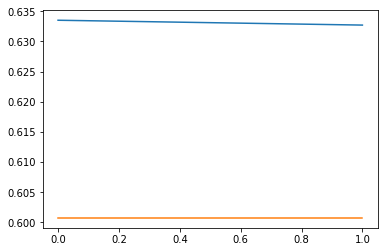

In [14]:
fig, ax = plt.subplots()
ax.plot(np.arange(len(train_loss_timeline)), train_loss_timeline, label="train")
ax.plot(np.arange(len(dev_loss_timeline)), dev_loss_timeline, label="dev")

In [13]:
eval_sampler = SequentialSampler(eval_dataset)

In [22]:
from sklearn.metrics import classification_report

label_map = {i: label for i, label in enumerate(possible_labels)}

out_label_list = [[] for _ in range(out_label_ids.shape[0])]
preds_list = [[] for _ in range(out_label_ids.shape[0])]

for i in range(out_label_ids.shape[0]):
    for j in range(out_label_ids.shape[1]):
        if out_label_ids[i, j] != pad_token_label_id:
            out_label_list[i].append(label_map[out_label_ids[i][j]])
            preds_list[i].append(label_map[preds[i][j]])

results = {
    "loss": eval_loss,
    "precision": precision_score(out_label_list, preds_list),
    "recall": recall_score(out_label_list, preds_list),
    "f1": f1_score([o for sentence in out_label_list for o in sentence], [p for sentence in preds_list for p in sentence])
}

trues = [o for sentence in out_label_list for o in sentence]
predicteds = [p for sentence in preds_list for p in sentence]

print(classification_report(trues, predicteds))

              precision    recall  f1-score   support

     B-claim       0.00      0.00      0.00      1428
     I-claim       0.59      0.66      0.62     16140
           O       0.81      0.79      0.80     31331

   micro avg       0.72      0.72      0.72     48899
   macro avg       0.46      0.48      0.47     48899
weighted avg       0.71      0.72      0.72     48899



In [75]:
with torch.cuda.device(1):
    eval_loss = eval_loss / nb_eval_steps
    preds = np.argmax(preds, axis=2)

    label_map = {i: label for i, label in enumerate(labels_test)}

    out_label_list = [[] for _ in range(out_label_ids.shape[0])]
    preds_list = [[] for _ in range(out_label_ids.shape[0])]

    for i in range(out_label_ids.shape[0]):
        for j in range(out_label_ids.shape[1]):
            if out_label_ids[i, j] != pad_token_label_id:
                out_label_list[i].append(label_map[out_label_ids[i][j]])
                preds_list[i].append(label_map[preds[i][j]])

    results = {
        "loss": eval_loss,
        "precision": precision_score(out_label_list, preds_list),
        "recall": recall_score(out_label_list, preds_list),
        "f1": f1_score(out_label_list, preds_list)
    }

KeyError: 15440

In [47]:
label_map[valid_tags[0]]


KeyError: tensor(-100, device='cuda:1')

# Test with SimpleTransformers

In [1]:
import transformers
import simpletransformers

transformers.__version__

I0120 20:59:27.730277 140119746860800 file_utils.py:35] PyTorch version 1.0.1 available.


'2.3.0'

In [1]:
import transformers
import sklearn
from transformers import AdamW, get_linear_schedule_with_warmup
from simpletransformers.classification import ClassificationModel
from simpletransformers.classification import MultiLabelClassificationModel
from simpletransformers.ner import NERModel
import pandas as pd
#simpletransformers.__version__

I0122 15:23:04.343995 140095059437312 file_utils.py:35] PyTorch version 1.0.1 available.


In [13]:
training_data = pd.read_csv("../train_mm.txt", sep='\t', encoding="latin1").fillna(method="ffill")
training_data = training_data.drop(columns=['idx', 'basura', 'basura.1'])
training_data = training_data.rename({'tag':'labels','sentence':'sentence_id', 'text': 'words'},axis=1)

Os_tr = training_data[training_data['labels'] == 'O']
claims_tr = training_data[training_data['labels'] == 'claim']

test_data = pd.read_csv("../test_mm.txt", sep='\t', encoding="latin1").fillna(method="ffill")
test_data = test_data.drop(columns=['idx', 'basura', 'basura.1'])
test_data = test_data.rename({'tag':'labels','sentence':'sentence_id', 'text': 'words'},axis=1)

Os_test = test_data[test_data['labels'] == 'O']
claims_test = test_data[test_data['labels'] == 'claim']

dev_data = pd.read_csv("../dev_mm.txt", sep='\t', encoding="latin1").fillna(method="ffill")
dev_data = dev_data.drop(columns=['idx', 'basura', 'basura.1'])
dev_data = dev_data.rename({'tag':'labels','sentence':'sentence_id', 'text': 'words'},axis=1)

Os_dev = dev_data[dev_data['labels'] == 'O']
claims_dev = dev_data[dev_data['labels'] == 'claim']

len(set(training_data['words'] + test_data['words'] + dev_data['words']))


39306

In [4]:

# dev_data

In [37]:
bert_model_finetune = NERModel('bert', 'bert-large-cased-2e-05-0.3-NER/epoch-30', args={'learning_rate': 2e-05, 'overwrite_output_dir': True, 'reprocess_input_data': True, 'num_train_epochs': 40, 'evaluate_during_training': True, 'attention_probs_dropout_prob': 0.1, 'hidden_dropout_prob': 0.1, 'evaluate_during_training_steps': 0, 'save_steps': 0, 'adam_epsilon': 1e-6, 'layer_norm_eps': 1e-8}, labels=['O', 'claim'])
result, model_outputs, predictions = bert_model_finetune.eval_model(test_data)

I0120 20:50:15.123761 139730880038656 configuration_utils.py:182] loading configuration file bert-large-cased-2e-05-0.3-NER/epoch-30/config.json
I0120 20:50:15.125301 139730880038656 configuration_utils.py:199] Model config {
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1"
  },
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "is_decoder": false,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "num_labels": 2,
  "output_attentions": false,
  "output_hidden_states": false,
  "output_past": true,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "pruned_heads": {},

Features loaded from cache at cache_dir/cached_dev_bert_128_2_2944



{'eval_loss': 1.731662270674296, 'precision': 0.5285972305839856, 'recall': 0.6076124567474048, 'f1_score': 0.5653573728267869}


In [29]:
test_data

,words,basura,basura.1,labels,sentence_id
0,<,_,_,O,0
1,?,_,_,O,0
2,xml,_,_,O,0
3,version=,_,_,O,0
4,\t_\t_\tO\t0\n5\t1.0\t_\t_\tO\t0\n6\t,_,_,O,0
5,encoding=,_,_,O,0
6,\t_\t_\tO\t0\n9\tUTF-8\t_\t_\tO\t0\n10\t,_,_,O,0
7,standalone=,_,_,O,0
8,\t_\t_\tO\t0\n13\tno\t_\t_\tO\t0\n14\t,_,_,O,0
9,?,_,_,O,0


In [5]:
for model_name in ['bert-large-cased', 'bert-base-cased']:
    for lr in [2e-5]:
            for dropout in [0.5]:
                # bert_model_finetune = MultiLabelClassificationModel('bert', 'bert-base-cased', num_labels=40, args={'reprocess_input_data': True, 'overwrite_output_dir': True, 'num_train_epochs': 5})
                bert_model_finetune = NERModel('bert', 'bert-large-cased', args={'learning_rate': lr, 'overwrite_output_dir': True, 'reprocess_input_data': True, 'num_train_epochs': 40, 'evaluate_during_training': True, 'attention_probs_dropout_prob': dropout, 'hidden_dropout_prob': dropout, 'evaluate_during_training_steps': 0, 'save_steps': 0, 'adam_epsilon': 1e-6, 'layer_norm_eps': 1e-8}, labels=['O','claim'])
                bert_model_finetune.train_model(training_data, output_dir='{}-{}-{}-NER'.format(model_name, str(lr), str(dropout)), eval_df=dev_data)

I0120 20:59:45.070146 140119746860800 configuration_utils.py:185] loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-cased-config.json from cache at /home/dfurman/.cache/torch/transformers/90deb4d9dd705272dc4b3db1364d759d551d72a9f70a91f60e3a1f5e278b985d.e1d0cd972de64b28f3a5bee0ffccda07658b2b3e827e0ef38c5799e9aaa23f19
I0120 20:59:45.072178 140119746860800 configuration_utils.py:199] Model config {
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1"
  },
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "is_decoder": false,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "num_labels": 2,
  "output_attentions": false,
  "output_hidden_states": f

Converting to features started.



Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


Running loss: 0.775404Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0
Running loss: 0.804383Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0
Running loss: 0.720014Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0
Running loss: 0.399931Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0
Running loss: 0.000537

I0120 21:16:38.278512 140119746860800 configuration_utils.py:87] Configuration saved in bert-large-cased-2e-05-0.5-NER/checkpoint-2077-epoch-1/config.json
I0120 21:16:39.357092 140119746860800 modeling_utils.py:258] Model weights saved in bert-large-cased-2e-05-0.5-NER/checkpoint-2077-epoch-1/pytorch_model.bin


Features loaded from cache at cache_dir/cached_dev_bert_128_2_2572


{'eval_loss': 0.27612751000404906, 'precision': 0.32796317606444186, 'recall': 0.5102954341987467, 'f1_score': 0.39929947460595444}


Running loss: 0.336047Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0
Running loss: 0.158711Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2048.0
Running loss: 0.042914

I0120 21:33:39.863944 140119746860800 configuration_utils.py:87] Configuration saved in bert-large-cased-2e-05-0.5-NER/checkpoint-4154-epoch-2/config.json
I0120 21:33:40.932261 140119746860800 modeling_utils.py:258] Model weights saved in bert-large-cased-2e-05-0.5-NER/checkpoint-4154-epoch-2/pytorch_model.bin


Features loaded from cache at cache_dir/cached_dev_bert_128_2_2572


{'eval_loss': 0.352754360337464, 'precision': 0.4481132075471698, 'recall': 0.5102954341987467, 'f1_score': 0.47718710757639177}


Running loss: 0.026624

I0120 21:50:41.675870 140119746860800 configuration_utils.py:87] Configuration saved in bert-large-cased-2e-05-0.5-NER/checkpoint-6231-epoch-3/config.json
I0120 21:50:42.737535 140119746860800 modeling_utils.py:258] Model weights saved in bert-large-cased-2e-05-0.5-NER/checkpoint-6231-epoch-3/pytorch_model.bin


Features loaded from cache at cache_dir/cached_dev_bert_128_2_2572


{'eval_loss': 0.37566860784208533, 'precision': 0.48721694667640614, 'recall': 0.5971351835273053, 'f1_score': 0.5366049879324217}


Running loss: 0.468723Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0
Running loss: 0.792234Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2048.0
Running loss: 0.207327

I0120 22:07:38.344489 140119746860800 configuration_utils.py:87] Configuration saved in bert-large-cased-2e-05-0.5-NER/checkpoint-8308-epoch-4/config.json
I0120 22:07:39.405170 140119746860800 modeling_utils.py:258] Model weights saved in bert-large-cased-2e-05-0.5-NER/checkpoint-8308-epoch-4/pytorch_model.bin


Features loaded from cache at cache_dir/cached_dev_bert_128_2_2572


{'eval_loss': 0.5331873169898527, 'precision': 0.5154320987654321, 'recall': 0.5980304386750224, 'f1_score': 0.5536676336510568}


Running loss: 0.004547

I0120 22:24:31.977072 140119746860800 configuration_utils.py:87] Configuration saved in bert-large-cased-2e-05-0.5-NER/checkpoint-10385-epoch-5/config.json
I0120 22:24:33.037290 140119746860800 modeling_utils.py:258] Model weights saved in bert-large-cased-2e-05-0.5-NER/checkpoint-10385-epoch-5/pytorch_model.bin


Features loaded from cache at cache_dir/cached_dev_bert_128_2_2572


{'eval_loss': 0.5061125582738354, 'precision': 0.5416012558869702, 'recall': 0.6177260519247986, 'f1_score': 0.5771643663739021}


Running loss: 1.032550Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0
Running loss: 0.692443Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2048.0
Running loss: 0.000150

I0120 22:41:22.693971 140119746860800 configuration_utils.py:87] Configuration saved in bert-large-cased-2e-05-0.5-NER/checkpoint-12462-epoch-6/config.json
I0120 22:41:23.755873 140119746860800 modeling_utils.py:258] Model weights saved in bert-large-cased-2e-05-0.5-NER/checkpoint-12462-epoch-6/pytorch_model.bin


Features loaded from cache at cache_dir/cached_dev_bert_128_2_2572


{'eval_loss': 0.6780100466974162, 'precision': 0.5705521472392638, 'recall': 0.5828111011638317, 'f1_score': 0.5766164747564216}


Running loss: 0.540218Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2048.0
Running loss: 0.000572

I0120 22:58:13.669118 140119746860800 configuration_utils.py:87] Configuration saved in bert-large-cased-2e-05-0.5-NER/checkpoint-14539-epoch-7/config.json
I0120 22:58:14.724601 140119746860800 modeling_utils.py:258] Model weights saved in bert-large-cased-2e-05-0.5-NER/checkpoint-14539-epoch-7/pytorch_model.bin


Features loaded from cache at cache_dir/cached_dev_bert_128_2_2572


{'eval_loss': 0.6579635992310393, 'precision': 0.5297215951843491, 'recall': 0.630259623992838, 'f1_score': 0.5756336876533115}


Running loss: 0.000053

I0120 23:15:03.577547 140119746860800 configuration_utils.py:87] Configuration saved in bert-large-cased-2e-05-0.5-NER/checkpoint-16616-epoch-8/config.json
I0120 23:15:04.634703 140119746860800 modeling_utils.py:258] Model weights saved in bert-large-cased-2e-05-0.5-NER/checkpoint-16616-epoch-8/pytorch_model.bin


Features loaded from cache at cache_dir/cached_dev_bert_128_2_2572


{'eval_loss': 0.8920748896130841, 'precision': 0.561698717948718, 'recall': 0.6275738585496866, 'f1_score': 0.5928118393234673}


Running loss: 1.603649Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2048.0
Running loss: 0.000060

I0120 23:31:51.781788 140119746860800 configuration_utils.py:87] Configuration saved in bert-large-cased-2e-05-0.5-NER/checkpoint-18693-epoch-9/config.json
I0120 23:31:52.839562 140119746860800 modeling_utils.py:258] Model weights saved in bert-large-cased-2e-05-0.5-NER/checkpoint-18693-epoch-9/pytorch_model.bin


Features loaded from cache at cache_dir/cached_dev_bert_128_2_2572


{'eval_loss': 0.8554794613552297, 'precision': 0.5773584905660377, 'recall': 0.5478961504028648, 'f1_score': 0.5622416169039963}


Running loss: 0.000019

I0120 23:48:40.643269 140119746860800 configuration_utils.py:87] Configuration saved in bert-large-cased-2e-05-0.5-NER/checkpoint-20770-epoch-10/config.json
I0120 23:48:41.696793 140119746860800 modeling_utils.py:258] Model weights saved in bert-large-cased-2e-05-0.5-NER/checkpoint-20770-epoch-10/pytorch_model.bin


Features loaded from cache at cache_dir/cached_dev_bert_128_2_2572


{'eval_loss': 0.7827854411869096, 'precision': 0.6163113994439295, 'recall': 0.5953446732318711, 'f1_score': 0.6056466302367942}


Running loss: 1.452292Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0
Running loss: 0.000107

I0121 00:05:28.687974 140119746860800 configuration_utils.py:87] Configuration saved in bert-large-cased-2e-05-0.5-NER/checkpoint-22847-epoch-11/config.json
I0121 00:05:29.742811 140119746860800 modeling_utils.py:258] Model weights saved in bert-large-cased-2e-05-0.5-NER/checkpoint-22847-epoch-11/pytorch_model.bin


Features loaded from cache at cache_dir/cached_dev_bert_128_2_2572


{'eval_loss': 0.8114190472556091, 'precision': 0.5535289452815226, 'recall': 0.6248880931065354, 'f1_score': 0.5870479394449116}


Running loss: 0.105945Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2048.0
Running loss: 0.535697

I0121 00:22:15.067525 140119746860800 configuration_utils.py:87] Configuration saved in bert-large-cased-2e-05-0.5-NER/checkpoint-24924-epoch-12/config.json
I0121 00:22:16.126687 140119746860800 modeling_utils.py:258] Model weights saved in bert-large-cased-2e-05-0.5-NER/checkpoint-24924-epoch-12/pytorch_model.bin


Features loaded from cache at cache_dir/cached_dev_bert_128_2_2572


{'eval_loss': 0.7925950484474009, 'precision': 0.583752093802345, 'recall': 0.6239928379588182, 'f1_score': 0.6032020770229338}


Running loss: 0.810204Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 1024.0
Running loss: 0.000236

I0121 00:39:04.702539 140119746860800 configuration_utils.py:87] Configuration saved in bert-large-cased-2e-05-0.5-NER/checkpoint-27001-epoch-13/config.json
I0121 00:39:05.758431 140119746860800 modeling_utils.py:258] Model weights saved in bert-large-cased-2e-05-0.5-NER/checkpoint-27001-epoch-13/pytorch_model.bin


Features loaded from cache at cache_dir/cached_dev_bert_128_2_2572


{'eval_loss': 0.7992647169075386, 'precision': 0.5606837606837607, 'recall': 0.5872873769024172, 'f1_score': 0.5736773065150853}


Running loss: 0.246550Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 1024.0
Running loss: 0.128991Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 512.0
Running loss: 0.000139

I0121 00:55:53.303460 140119746860800 configuration_utils.py:87] Configuration saved in bert-large-cased-2e-05-0.5-NER/checkpoint-29078-epoch-14/config.json
I0121 00:55:54.357126 140119746860800 modeling_utils.py:258] Model weights saved in bert-large-cased-2e-05-0.5-NER/checkpoint-29078-epoch-14/pytorch_model.bin


Features loaded from cache at cache_dir/cached_dev_bert_128_2_2572


{'eval_loss': 0.8158921221088828, 'precision': 0.5993091537132987, 'recall': 0.621307072515667, 'f1_score': 0.61010989010989}


Running loss: 0.000014

I0121 01:12:40.516248 140119746860800 configuration_utils.py:87] Configuration saved in bert-large-cased-2e-05-0.5-NER/checkpoint-31155-epoch-15/config.json
I0121 01:12:41.564037 140119746860800 modeling_utils.py:258] Model weights saved in bert-large-cased-2e-05-0.5-NER/checkpoint-31155-epoch-15/pytorch_model.bin


Features loaded from cache at cache_dir/cached_dev_bert_128_2_2572


{'eval_loss': 0.9142441054553256, 'precision': 0.5852225020990764, 'recall': 0.6239928379588182, 'f1_score': 0.6039861351819757}


Running loss: 0.000019

I0121 01:29:24.904416 140119746860800 configuration_utils.py:87] Configuration saved in bert-large-cased-2e-05-0.5-NER/checkpoint-33232-epoch-16/config.json
I0121 01:29:25.952104 140119746860800 modeling_utils.py:258] Model weights saved in bert-large-cased-2e-05-0.5-NER/checkpoint-33232-epoch-16/pytorch_model.bin


Features loaded from cache at cache_dir/cached_dev_bert_128_2_2572


{'eval_loss': 0.9652993901371932, 'precision': 0.5534136546184739, 'recall': 0.6168307967770814, 'f1_score': 0.5834038950042336}


Running loss: 1.001015Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2048.0
Running loss: 0.511564Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 1024.0
Running loss: 0.001051

I0121 01:46:11.229010 140119746860800 configuration_utils.py:87] Configuration saved in bert-large-cased-2e-05-0.5-NER/checkpoint-35309-epoch-17/config.json
I0121 01:46:12.284790 140119746860800 modeling_utils.py:258] Model weights saved in bert-large-cased-2e-05-0.5-NER/checkpoint-35309-epoch-17/pytorch_model.bin


Features loaded from cache at cache_dir/cached_dev_bert_128_2_2572


{'eval_loss': 0.7553525311327773, 'precision': 0.584731543624161, 'recall': 0.6239928379588182, 'f1_score': 0.6037245560848853}


Running loss: 0.000132

I0121 02:02:57.102549 140119746860800 configuration_utils.py:87] Configuration saved in bert-large-cased-2e-05-0.5-NER/checkpoint-37386-epoch-18/config.json
I0121 02:02:58.158646 140119746860800 modeling_utils.py:258] Model weights saved in bert-large-cased-2e-05-0.5-NER/checkpoint-37386-epoch-18/pytorch_model.bin


Features loaded from cache at cache_dir/cached_dev_bert_128_2_2572


{'eval_loss': 0.8723114632644832, 'precision': 0.6116681859617138, 'recall': 0.6007162041181737, 'f1_score': 0.6061427280939476}


Running loss: 0.000029

I0121 02:19:43.888034 140119746860800 configuration_utils.py:87] Configuration saved in bert-large-cased-2e-05-0.5-NER/checkpoint-39463-epoch-19/config.json
I0121 02:19:45.365983 140119746860800 modeling_utils.py:258] Model weights saved in bert-large-cased-2e-05-0.5-NER/checkpoint-39463-epoch-19/pytorch_model.bin


Features loaded from cache at cache_dir/cached_dev_bert_128_2_2572


{'eval_loss': 0.8804340145194367, 'precision': 0.5905292479108635, 'recall': 0.5693822739480752, 'f1_score': 0.5797629899726526}


Running loss: 0.048034Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0
Running loss: 0.000022

I0121 02:36:31.220669 140119746860800 configuration_utils.py:87] Configuration saved in bert-large-cased-2e-05-0.5-NER/checkpoint-41540-epoch-20/config.json
I0121 02:36:32.514389 140119746860800 modeling_utils.py:258] Model weights saved in bert-large-cased-2e-05-0.5-NER/checkpoint-41540-epoch-20/pytorch_model.bin


Features loaded from cache at cache_dir/cached_dev_bert_128_2_2572


{'eval_loss': 0.9510506940102208, 'precision': 0.564625850340136, 'recall': 0.594449418084154, 'f1_score': 0.5791539467945922}


Running loss: 0.108492Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2048.0
Running loss: 0.000039

I0121 02:53:17.645808 140119746860800 configuration_utils.py:87] Configuration saved in bert-large-cased-2e-05-0.5-NER/checkpoint-43617-epoch-21/config.json
I0121 02:53:19.509386 140119746860800 modeling_utils.py:258] Model weights saved in bert-large-cased-2e-05-0.5-NER/checkpoint-43617-epoch-21/pytorch_model.bin


Features loaded from cache at cache_dir/cached_dev_bert_128_2_2572


{'eval_loss': 0.9105629392156883, 'precision': 0.5699272433306386, 'recall': 0.631154879140555, 'f1_score': 0.5989804587935428}


Running loss: 0.000040

I0121 03:10:03.878893 140119746860800 configuration_utils.py:87] Configuration saved in bert-large-cased-2e-05-0.5-NER/checkpoint-45694-epoch-22/config.json
I0121 03:10:04.963408 140119746860800 modeling_utils.py:258] Model weights saved in bert-large-cased-2e-05-0.5-NER/checkpoint-45694-epoch-22/pytorch_model.bin


Features loaded from cache at cache_dir/cached_dev_bert_128_2_2572


{'eval_loss': 0.9674337332287634, 'precision': 0.5955056179775281, 'recall': 0.6168307967770814, 'f1_score': 0.6059806508355322}


Running loss: 0.180155Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0
Running loss: 0.310895Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2048.0
Running loss: 0.000035

I0121 03:26:48.155251 140119746860800 configuration_utils.py:87] Configuration saved in bert-large-cased-2e-05-0.5-NER/checkpoint-47771-epoch-23/config.json
I0121 03:26:49.234647 140119746860800 modeling_utils.py:258] Model weights saved in bert-large-cased-2e-05-0.5-NER/checkpoint-47771-epoch-23/pytorch_model.bin


Features loaded from cache at cache_dir/cached_dev_bert_128_2_2572


{'eval_loss': 0.9614420475147936, 'precision': 0.5700560448358687, 'recall': 0.6374216651745748, 'f1_score': 0.6018596787827557}


Running loss: 0.000009

I0121 03:43:32.956813 140119746860800 configuration_utils.py:87] Configuration saved in bert-large-cased-2e-05-0.5-NER/checkpoint-49848-epoch-24/config.json
I0121 03:43:34.019321 140119746860800 modeling_utils.py:258] Model weights saved in bert-large-cased-2e-05-0.5-NER/checkpoint-49848-epoch-24/pytorch_model.bin


Features loaded from cache at cache_dir/cached_dev_bert_128_2_2572


{'eval_loss': 1.0184832816561884, 'precision': 0.5573899371069182, 'recall': 0.6347358997314234, 'f1_score': 0.5935537881958978}


Running loss: 0.000010

I0121 04:00:19.786113 140119746860800 configuration_utils.py:87] Configuration saved in bert-large-cased-2e-05-0.5-NER/checkpoint-51925-epoch-25/config.json
I0121 04:00:20.851803 140119746860800 modeling_utils.py:258] Model weights saved in bert-large-cased-2e-05-0.5-NER/checkpoint-51925-epoch-25/pytorch_model.bin


Features loaded from cache at cache_dir/cached_dev_bert_128_2_2572


{'eval_loss': 0.8610528161707379, 'precision': 0.6007036059806509, 'recall': 0.6114592658907789, 'f1_score': 0.6060337178349601}


Running loss: 0.031437Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0
Running loss: 0.000014

I0121 04:17:06.145317 140119746860800 configuration_utils.py:87] Configuration saved in bert-large-cased-2e-05-0.5-NER/checkpoint-54002-epoch-26/config.json
I0121 04:17:07.207900 140119746860800 modeling_utils.py:258] Model weights saved in bert-large-cased-2e-05-0.5-NER/checkpoint-54002-epoch-26/pytorch_model.bin


Features loaded from cache at cache_dir/cached_dev_bert_128_2_2572


{'eval_loss': 0.8848783073028091, 'precision': 0.5726767275615567, 'recall': 0.6454789615040286, 'f1_score': 0.6069023569023568}


Running loss: 0.401641Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0
Running loss: 0.000017

I0121 04:33:53.996324 140119746860800 configuration_utils.py:87] Configuration saved in bert-large-cased-2e-05-0.5-NER/checkpoint-56079-epoch-27/config.json
I0121 04:33:55.420386 140119746860800 modeling_utils.py:258] Model weights saved in bert-large-cased-2e-05-0.5-NER/checkpoint-56079-epoch-27/pytorch_model.bin


Features loaded from cache at cache_dir/cached_dev_bert_128_2_2572


{'eval_loss': 0.9505494885520985, 'precision': 0.6026785714285714, 'recall': 0.6042972247090421, 'f1_score': 0.6034868126955745}


Running loss: 0.214421Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2048.0
Running loss: 0.000016

I0121 04:50:39.782052 140119746860800 configuration_utils.py:87] Configuration saved in bert-large-cased-2e-05-0.5-NER/checkpoint-58156-epoch-28/config.json
I0121 04:50:40.900873 140119746860800 modeling_utils.py:258] Model weights saved in bert-large-cased-2e-05-0.5-NER/checkpoint-58156-epoch-28/pytorch_model.bin


Features loaded from cache at cache_dir/cached_dev_bert_128_2_2572


{'eval_loss': 0.9559664038864463, 'precision': 0.606140350877193, 'recall': 0.6186213070725156, 'f1_score': 0.612317235268055}


Running loss: 0.000015

I0121 05:07:26.444747 140119746860800 configuration_utils.py:87] Configuration saved in bert-large-cased-2e-05-0.5-NER/checkpoint-60233-epoch-29/config.json
I0121 05:07:27.555258 140119746860800 modeling_utils.py:258] Model weights saved in bert-large-cased-2e-05-0.5-NER/checkpoint-60233-epoch-29/pytorch_model.bin


Features loaded from cache at cache_dir/cached_dev_bert_128_2_2572


{'eval_loss': 1.0134771007541183, 'precision': 0.6102430555555556, 'recall': 0.6293643688451208, 'f1_score': 0.6196562362274131}


Running loss: 0.395793Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2048.0
Running loss: 0.000005

I0121 05:24:10.765224 140119746860800 configuration_utils.py:87] Configuration saved in bert-large-cased-2e-05-0.5-NER/checkpoint-62310-epoch-30/config.json
I0121 05:24:11.853690 140119746860800 modeling_utils.py:258] Model weights saved in bert-large-cased-2e-05-0.5-NER/checkpoint-62310-epoch-30/pytorch_model.bin


Features loaded from cache at cache_dir/cached_dev_bert_128_2_2572


{'eval_loss': 1.0471791391030485, 'precision': 0.6202090592334495, 'recall': 0.6374216651745748, 'f1_score': 0.6286975717439294}


Running loss: 0.000005

I0121 05:40:56.725964 140119746860800 configuration_utils.py:87] Configuration saved in bert-large-cased-2e-05-0.5-NER/checkpoint-64387-epoch-31/config.json
I0121 05:40:57.803461 140119746860800 modeling_utils.py:258] Model weights saved in bert-large-cased-2e-05-0.5-NER/checkpoint-64387-epoch-31/pytorch_model.bin


Features loaded from cache at cache_dir/cached_dev_bert_128_2_2572


{'eval_loss': 1.0900333650613412, 'precision': 0.6219298245614036, 'recall': 0.6347358997314234, 'f1_score': 0.6282676118741692}


Running loss: 0.000004

I0121 05:57:42.364268 140119746860800 configuration_utils.py:87] Configuration saved in bert-large-cased-2e-05-0.5-NER/checkpoint-66464-epoch-32/config.json
I0121 05:57:43.420659 140119746860800 modeling_utils.py:258] Model weights saved in bert-large-cased-2e-05-0.5-NER/checkpoint-66464-epoch-32/pytorch_model.bin


Features loaded from cache at cache_dir/cached_dev_bert_128_2_2572


{'eval_loss': 1.1099970507414318, 'precision': 0.612565445026178, 'recall': 0.6284691136974038, 'f1_score': 0.620415377817057}


Running loss: 0.220776Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0
Running loss: 0.000002

I0121 06:14:27.604076 140119746860800 configuration_utils.py:87] Configuration saved in bert-large-cased-2e-05-0.5-NER/checkpoint-68541-epoch-33/config.json
I0121 06:14:28.684007 140119746860800 modeling_utils.py:258] Model weights saved in bert-large-cased-2e-05-0.5-NER/checkpoint-68541-epoch-33/pytorch_model.bin


Features loaded from cache at cache_dir/cached_dev_bert_128_2_2572


{'eval_loss': 1.1297631570509612, 'precision': 0.6097137901127494, 'recall': 0.6293643688451208, 'f1_score': 0.6193832599118944}


Running loss: 0.260521Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0
Running loss: 0.000004

I0121 06:31:14.204456 140119746860800 configuration_utils.py:87] Configuration saved in bert-large-cased-2e-05-0.5-NER/checkpoint-70618-epoch-34/config.json
I0121 06:31:15.275340 140119746860800 modeling_utils.py:258] Model weights saved in bert-large-cased-2e-05-0.5-NER/checkpoint-70618-epoch-34/pytorch_model.bin


Features loaded from cache at cache_dir/cached_dev_bert_128_2_2572


{'eval_loss': 1.1351173073952532, 'precision': 0.6201413427561837, 'recall': 0.6284691136974038, 'f1_score': 0.6242774566473988}


Running loss: 0.064163Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0
Running loss: 0.000004

I0121 06:47:59.996904 140119746860800 configuration_utils.py:87] Configuration saved in bert-large-cased-2e-05-0.5-NER/checkpoint-72695-epoch-35/config.json
I0121 06:48:01.062750 140119746860800 modeling_utils.py:258] Model weights saved in bert-large-cased-2e-05-0.5-NER/checkpoint-72695-epoch-35/pytorch_model.bin


Features loaded from cache at cache_dir/cached_dev_bert_128_2_2572


{'eval_loss': 1.1498289335732772, 'precision': 0.6076058772687987, 'recall': 0.6293643688451208, 'f1_score': 0.6182937554969218}


Running loss: 0.126578Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0
Running loss: 0.000003

I0121 07:04:45.785228 140119746860800 configuration_utils.py:87] Configuration saved in bert-large-cased-2e-05-0.5-NER/checkpoint-74772-epoch-36/config.json
I0121 07:04:46.846876 140119746860800 modeling_utils.py:258] Model weights saved in bert-large-cased-2e-05-0.5-NER/checkpoint-74772-epoch-36/pytorch_model.bin


Features loaded from cache at cache_dir/cached_dev_bert_128_2_2572


{'eval_loss': 1.1559488452484266, 'precision': 0.6131004366812227, 'recall': 0.6284691136974038, 'f1_score': 0.6206896551724138}


Running loss: 0.000002

I0121 07:21:28.735474 140119746860800 configuration_utils.py:87] Configuration saved in bert-large-cased-2e-05-0.5-NER/checkpoint-76849-epoch-37/config.json
I0121 07:21:29.808247 140119746860800 modeling_utils.py:258] Model weights saved in bert-large-cased-2e-05-0.5-NER/checkpoint-76849-epoch-37/pytorch_model.bin


Features loaded from cache at cache_dir/cached_dev_bert_128_2_2572


{'eval_loss': 1.198674047628947, 'precision': 0.6357615894039735, 'recall': 0.6016114592658908, 'f1_score': 0.6182152713891443}


Running loss: 0.000002

I0121 07:38:13.296499 140119746860800 configuration_utils.py:87] Configuration saved in bert-large-cased-2e-05-0.5-NER/checkpoint-78926-epoch-38/config.json
I0121 07:38:14.388313 140119746860800 modeling_utils.py:258] Model weights saved in bert-large-cased-2e-05-0.5-NER/checkpoint-78926-epoch-38/pytorch_model.bin


Features loaded from cache at cache_dir/cached_dev_bert_128_2_2572


{'eval_loss': 1.1979070692646845, 'precision': 0.6369606003752345, 'recall': 0.6078782452999105, 'f1_score': 0.6220797068254695}


Running loss: 0.000003

I0121 07:54:59.700253 140119746860800 configuration_utils.py:87] Configuration saved in bert-large-cased-2e-05-0.5-NER/checkpoint-81003-epoch-39/config.json
I0121 07:55:00.752440 140119746860800 modeling_utils.py:258] Model weights saved in bert-large-cased-2e-05-0.5-NER/checkpoint-81003-epoch-39/pytorch_model.bin


Features loaded from cache at cache_dir/cached_dev_bert_128_2_2572


{'eval_loss': 1.2009268919658378, 'precision': 0.6357677902621723, 'recall': 0.6078782452999105, 'f1_score': 0.6215102974828376}


Running loss: 0.000003

I0121 08:11:45.881578 140119746860800 configuration_utils.py:87] Configuration saved in bert-large-cased-2e-05-0.5-NER/checkpoint-83080-epoch-40/config.json
I0121 08:11:46.937293 140119746860800 modeling_utils.py:258] Model weights saved in bert-large-cased-2e-05-0.5-NER/checkpoint-83080-epoch-40/pytorch_model.bin


Features loaded from cache at cache_dir/cached_dev_bert_128_2_2572


I0121 08:12:23.709295 140119746860800 configuration_utils.py:87] Configuration saved in bert-large-cased-2e-05-0.5-NER/config.json


{'eval_loss': 1.2025249863125633, 'precision': 0.6357677902621723, 'recall': 0.6078782452999105, 'f1_score': 0.6215102974828376}



I0121 08:12:24.763299 140119746860800 modeling_utils.py:258] Model weights saved in bert-large-cased-2e-05-0.5-NER/pytorch_model.bin


Training of bert model complete. Saved to bert-large-cased-2e-05-0.5-NER.


I0121 08:12:25.572598 140119746860800 configuration_utils.py:185] loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-cased-config.json from cache at /home/dfurman/.cache/torch/transformers/90deb4d9dd705272dc4b3db1364d759d551d72a9f70a91f60e3a1f5e278b985d.e1d0cd972de64b28f3a5bee0ffccda07658b2b3e827e0ef38c5799e9aaa23f19
I0121 08:12:25.574185 140119746860800 configuration_utils.py:199] Model config {
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1"
  },
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "is_decoder": false,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "num_labels": 2,
  "output_attentions": false,
  "output_hidden_states": f

Converting to features started.



Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


Running loss: 0.735363

RuntimeError: CUDA out of memory. Tried to allocate 16.00 MiB (GPU 0; 10.92 GiB total capacity; 10.45 GiB already allocated; 9.50 MiB free; 34.47 MiB cached)

In [ ]:
# Evaluate the model
result, model_outputs, predictions = bert_model_finetune.eval_model(dev_data)

In [68]:
predictions, raw_outputs = bert_model_finetune.predict(["Beacuse this is an argument, it will be cached by the model"])

Converting to features started.


In [69]:
print(predictions)

[[{'Beacuse': 'O'}, {'this': 'O'}, {'is': 'O'}, {'an': 'O'}, {'argument,': 'O'}, {'it': 'claim'}, {'will': 'claim'}, {'be': 'claim'}, {'cached': 'claim'}, {'by': 'claim'}, {'the': 'claim'}, {'model': 'claim'}]]


In [ ]:
bert_model_finetune.save()